<a href="https://colab.research.google.com/github/xfo-03/Sequential-POI-recommendation/blob/main/Data_Preprocessing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Geohash

The geohashing was done separately and the hashed dataset is imported directly in this file for further processing.

In [ ]:
import numpy as np
import pandas as pd
import pyproj
import pygeohash as pgh
import dask.dataframe as dd


def convert_projection_to_latlon_vectorized(x, y, source_proj, target_proj):
    transformer = pyproj.Transformer.from_proj(source_proj, target_proj, always_xy=True)
    lon, lat = transformer.transform(x.values, y.values)
    return lat, lon


def convert_projection_to_latlon_dask(df, source_proj, target_proj):
    transformer = pyproj.Transformer.from_proj(source_proj, target_proj, always_xy=True)
    lon, lat = transformer.transform(df['X'].values, df['Y'].values)
    df['Latitude'] = lat
    df['Longitude'] = lon
    return df


if __name__ == '__main__':
    ddf = dd.read_csv("CheckIns.tsv", sep="\t")
    print(f"Original length: {len(ddf)}")

    # Define the source projection for Atlanta (UTM zone 16N, WGS84)
    source_proj = pyproj.CRS(proj='utm', zone=16, datum='WGS84')
    target_proj = pyproj.CRS(proj='latlong', datum='WGS84')

    # Convert the coordinates using Dask's map_partitions
    ddf = ddf.map_partitions(lambda df: convert_projection_to_latlon_dask(df, source_proj, target_proj))

    # Drop the original X and Y columns
    ddf = ddf.drop(columns=['X', 'Y'])

    # Rename the Latitude and Longitude columns to X and Y
    ddf = ddf.rename(columns={'Latitude': 'X', 'Longitude': 'Y'})

    # Add a new column for geohash with precision 6
    ddf['Geohash'] = ddf.map_partitions(lambda df: df.apply(lambda row: pgh.encode(row['X'], row['Y'], precision=6), axis=1))

    # Save the updated DataFrame to a new file
    ddf.to_csv("CheckIns_with_geohash.csv", index=False, single_file=True)

    #data = pd.read_csv("CheckIns_with_geohash.csv")
    #
    # # Expand Geohash into individual character features
    # geohash_expansion = data['Geohash'].apply(lambda x: pd.Series(list(x)))
    # geohash_expansion.columns = [f'Geohash_{i}' for i in range(geohash_expansion.shape[1])]
    #
    # # Concatenate the original data with the expanded geohash
    # data = pd.concat([data, geohash_expansion], axis = 1)
    #
    # # Display the transformed data
    # print(data.head())
    #
    # # Save the transformed data
    # data.to_csv("CheckIns_with_expanded_geohash.csv", index = False)


##Import

In [ ]:
import pandas as pd
import numpy as np
import torch

In [ ]:
from sklearn.preprocessing import LabelEncoder, MinMaxScaler

##Dataset


In [ ]:
CheckIns_df = pd.read_csv('/content/drive/MyDrive/Spatio_Temporal_Lab/CheckIns_with_numerical_geohash.csv')
CheckIns_df[['Date', 'Time']] = CheckIns_df['CheckinTime'].str.split('T', expand=True)
CheckIns_df.drop(columns=['CheckinTime'], inplace=True)
CheckIns_df.head()

,UserId,VenueId,VenueType,X,Y,Geohash,Geohash_0,Geohash_1,Geohash_2,Geohash_3,Geohash_4,Geohash_5,Date,Time
0,103,1755,Pub,33.746451,-84.378363,djgzzz,13,19,16,35,35,35,2019-07-01,05:45:00
1,656,1773,Restaurant,33.737971,-84.398460,djgzzm,13,19,16,35,35,22,2019-07-01,05:45:00
2,787,1752,Pub,33.751803,-84.377279,dn5bpb,13,23,5,11,25,11,2019-07-01,05:45:00
3,828,1752,Pub,33.751803,-84.377279,dn5bpb,13,23,5,11,25,11,2019-07-01,05:50:00
4,244,1754,Pub,33.756357,-84.389157,dn5bp9,13,23,5,11,25,9,2019-07-01,05:55:00


In [ ]:
len(CheckIns_df)

2481774

##Pre-processing



*   Feat. engineering of new features
*   Add season categorization
*   Part of the day
*   Binary Classificatioon - Weekend: 0; Weekday: 1
*   Day of the week



In [ ]:
features_df = CheckIns_df
features_df.drop(columns = ['Geohash'], inplace = True)

# Concatenate columns Geohash_0 to Geohash_5 into a new column 'GeoHash'
features_df['GeoHash'] = features_df.apply(lambda row: ''.join([str(row[f'Geohash_{i}']) for i in range(6)]), axis=1)

# Drop the original Geohash_0 to Geohash_5 columns if needed
features_df.drop(columns=['Geohash_0', 'Geohash_1', 'Geohash_2', 'Geohash_3', 'Geohash_4', 'Geohash_5'], inplace=True)

features_df.drop(columns=['X', 'Y'], inplace=True)

# Ensure UserId and VenueId are integers
features_df['UserId'] = features_df['UserId'].astype(int)
features_df['VenueId'] = features_df['VenueId'].astype(int)

#One hot encoding of Venue Types
# Initialize LabelEncoder
label_encoder = LabelEncoder()
# Fit and transform the 'VenueType' column
features_df['VenueType'] = label_encoder.fit_transform(features_df['VenueType'])

# Print the mapping
venue_type_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
print(venue_type_mapping)

{'Apartment': 0, 'Pub': 1, 'Restaurant': 2, 'Workplace': 3}


In [ ]:
# Convert Date and Time
features_df['Date'] = pd.to_datetime(features_df['Date'])
features_df['Time'] = pd.to_datetime(features_df['Time'], format='%H:%M:%S').dt.time

# Preprocess Date to extract Year, Month, and Day
features_df['Date'] = pd.to_datetime(features_df['Date'])
features_df['Year'] = features_df['Date'].dt.year
features_df['Month'] = features_df['Date'].dt.month
features_df['Day'] = features_df['Date'].dt.day

# Drop the original Date column
#features_df.drop(columns=['Date'], inplace=True)

In [ ]:
#Change time to hour min sec

# Extract hour, minute, and second
features_df['Time'] = pd.to_datetime(features_df['Time'], format='%H:%M:%S').dt.time

# Convert 'Time' column to datetime by combining with a dummy date
features_df['Time'] = pd.to_datetime(features_df['Time'].astype(str))

# Extract hour, minute, and second
features_df['hour'] = features_df['Time'].dt.hour
features_df['minute'] = features_df['Time'].dt.minute
features_df['second'] = features_df['Time'].dt.second

<ipython-input-7-67f846c30b4e>:7: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  features_df['Time'] = pd.to_datetime(features_df['Time'].astype(str))


In [ ]:
#Add season categorization
#Create new column 'Season'
conditions = [
    (features_df['Month'] == 12) | (features_df['Month'] == 1) | (features_df['Month'] == 2),
    (features_df['Month'] >= 3) & (features_df['Month'] <= 5),
    (features_df['Month'] >= 6) & (features_df['Month'] <= 8),
    (features_df['Month'] >= 9) & (features_df['Month'] <= 11)
]

choices = [1, 2, 3, 4]

features_df['Season'] = np.select(conditions, choices, default=np.nan)
#print(features_df[features_df['dayofweek'] == 1])

In [ ]:
#Part of the day
conditions = [
    (features_df['hour'] >= 0) & (features_df['hour'] < 6),
    (features_df['hour'] >= 6) & (features_df['hour'] < 12),
    (features_df['hour'] >= 12) & (features_df['hour'] < 18),
    (features_df['hour'] >= 18) & (features_df['hour'] < 24)
]

choices = ['1', '2', '3', '4']

# Create the 'Part of Day' column using np.select
features_df['Part of Day'] = np.select(conditions, choices, default=np.nan)


In [ ]:
#Binary Classificatioon - Weekend: 0; Weekday: 1

# Ensure 'datetime' column is in datetime format
features_df['Date'] = pd.to_datetime(features_df['Date'])

# Extract day of the week (0=Monday, 6=Sunday)
features_df['dayofweek'] = features_df['Date'].dt.dayofweek

# Classify as weekday (1) or weekend (0)
features_df['is_weekday'] = features_df['dayofweek'].apply(lambda x: 1 if x < 5 else 0)


In [ ]:
# Convert 'Season' column from float to int
features_df['Season'] = features_df['Season'].astype(int)

#Removing irrelevant columns
features_df.drop(columns=['Year', 'Day', 'minute', 'second', 'Time'],  inplace=True)

In [ ]:
filename = 'Add_Features_CheckIns.tsv'
file_path_tsv = '/content/drive/MyDrive/Spatio_Temporal_Lab/Add_Features_CheckIns.tsv'
features_df.to_csv(file_path_tsv, sep='\t', index=False)

##Sample EDA on feature dataset

In [ ]:
# Count data points for each day of the week
dayofweek_counts = features_df['dayofweek'].value_counts().sort_index()

# Count weekday and weekend data points
weekday_counts = features_df[features_df['is_weekday'] == 1].shape[0]
weekend_counts = features_df[features_df['is_weekday'] == 0].shape[0]

# Print results
print("Counts of data points for each day of the week:")
print(dayofweek_counts)
print("\nCount of weekday data points:", weekday_counts)
print("Count of weekend data points:", weekend_counts)

Counts of data points for each day of the week:
dayofweek
0    366032
1    355052
2    345256
3    344838
4    352930
5    355551
6    362115
Name: count, dtype: int64

Count of weekday data points: 1764108
Count of weekend data points: 717666


In [ ]:
df = features_df

# Create a column representing the 15-day period
df['15DayPeriod'] = (df['Date'] - df['Date'].min()).dt.days // 15

# Group by UserId and 15DayPeriod, and count the number of POIs visited each 15-day period
user_15day_pois = df.groupby(['UserId', '15DayPeriod']).size().reset_index(name='POICount')

# Calculate the average POIs visited per 15 days for each user
average_pois_per_user_15days = user_15day_pois.groupby('UserId')['POICount'].mean().reset_index(name='AveragePOIsPer15Days')

# Calculate the overall average POIs visited per 15 days for all users
overall_average_pois_per_15days = user_15day_pois['POICount'].mean()

print("Average POIs visited per 15 days for each user:")
print(average_pois_per_user_15days)
print("\nOverall average POIs visited per 15 days for all users:")
print(overall_average_pois_per_15days)


Average POIs visited per 15 days for each user:
     UserId  AveragePOIsPer15Days
0         0             54.300000
1         1            100.666667
2         2             80.233333
3         3             72.733333
4         4             52.333333
..      ...                   ...
995     995             73.866667
996     996            116.266667
997     997            110.200000
998     998             83.333333
999     999             81.766667

[1000 rows x 2 columns]

Overall average POIs visited per 15 days for all users:
82.7258


In [ ]:
df = features_df

# Create a column representing the 10-day period
df['10DayPeriod'] = (df['Date'] - df['Date'].min()).dt.days // 10

# Group by UserId and 10DayPeriod, and count the number of POIs visited each 10-day period
user_10day_pois = df.groupby(['UserId', '10DayPeriod']).size().reset_index(name='POICount')

# Calculate the average POIs visited per 10 days for each user
average_pois_per_user_10days = user_10day_pois.groupby('UserId')['POICount'].mean().reset_index(name='AveragePOIsPer7Days')

# Calculate the overall average POIs visited per 10 days for all users
overall_average_pois_per_10days = user_10day_pois['POICount'].mean()

print("Average POIs visited per 10 days for each user:")
print(average_pois_per_user_10days)
print("\nOverall average POIs visited per 10 days for all users:")
print(overall_average_pois_per_10days)


Average POIs visited per 10 days for each user:
     UserId  AveragePOIsPer7Days
0         0            36.200000
1         1            67.111111
2         2            53.488889
3         3            48.488889
4         4            34.888889
..      ...                  ...
995     995            49.244444
996     996            77.511111
997     997            73.466667
998     998            55.555556
999     999            54.511111

[1000 rows x 2 columns]

Overall average POIs visited per 10 days for all users:
55.150533333333335


In [ ]:
df = features_df


df['30DayPeriod'] = (df['Date'] - df['Date'].min()).dt.days // 30
user_30day_pois = df.groupby(['UserId', '30DayPeriod']).size().reset_index(name='POICount')
average_pois_per_user_30days = user_30day_pois.groupby('UserId')['POICount'].mean().reset_index(name='AveragePOIsPer30Days')
overall_average_pois_per_30days = user_30day_pois['POICount'].mean()

print("Average POIs visited per 30 days for each user:")
print(average_pois_per_user_30days)
print("\nOverall average POIs visited per 30 days for all users:")
print(overall_average_pois_per_30days)


Average POIs visited per 30 days for each user:
     UserId  AveragePOIsPer30Days
0         0            108.600000
1         1            201.333333
2         2            160.466667
3         3            145.466667
4         4            104.666667
..      ...                   ...
995     995            147.733333
996     996            232.533333
997     997            220.400000
998     998            166.666667
999     999            163.533333

[1000 rows x 2 columns]

Overall average POIs visited per 30 days for all users:
165.4516


In [ ]:
df = features_df
# Function to calculate median POIs visited
def median_pois(df, period):
    df['Period'] = df['Date'].dt.to_period(period)
    pois_per_period = df.groupby(['UserId', 'Period'])['VenueId'].nunique().reset_index()
    median_pois = pois_per_period.groupby('UserId')['VenueId'].median().reset_index()
    median_pois.columns = ['UserId', f'Median_POIs_{period}']
    return median_pois

# Calculate median POIs for 15 days and 10 days
median_pois_15_days = median_pois(df, '15D')
median_pois_10_days = median_pois(df, '10D')

print("Median POIs for 15 days:")
print(median_pois_15_days)

print("\nMedian POIs for 10 days:")
print(median_pois_10_days)
# Compute the overall median of POIs visited per 10 days
overall_median_pois_per_10days = median_pois_10_days[f'Median_POIs_10D'].median()

print("Overall Median POIs per 10 days:", overall_median_pois_per_10days)

Median POIs for 15 days:
     UserId  Median_POIs_15D
0         0              2.0
1         1              4.0
2         2              3.0
3         3              2.0
4         4              3.0
..      ...              ...
995     995              3.0
996     996              4.0
997     997              4.0
998     998              3.0
999     999              3.0

[1000 rows x 2 columns]

Median POIs for 10 days:
     UserId  Median_POIs_10D
0         0              2.0
1         1              4.0
2         2              3.0
3         3              2.0
4         4              3.0
..      ...              ...
995     995              3.0
996     996              4.0
997     997              4.0
998     998              3.0
999     999              3.0

[1000 rows x 2 columns]
Overall Median POIs per 10 days: 3.0


In [ ]:
# Group by UserId and get the first entry for each user
first_entries = df.groupby('UserId').first().reset_index()

print(first_entries)

     UserId  VenueId  VenueType       Date       GeoHash  Month  hour  Season  \
0         0     1708          3 2019-07-01    1323511259      7     7       3   
1         1     1773          2 2019-07-01  131916353522      7     7       3   
2         2     1685          3 2019-07-01    1323511258      7     7       3   
3         3     1743          3 2019-07-01  131916353532      7     8       3   
4         4     1710          3 2019-07-01    1323511252      7     7       3   
..      ...      ...        ...        ...           ...    ...   ...     ...   
995     995     1748          3 2019-07-01   13235112512      7     7       3   
996     996     1702          3 2019-07-01   13235112513      7     7       3   
997     997     1773          2 2019-07-01  131916353522      7     7       3   
998     998     1620          3 2019-07-01    1323511252      7     7       3   
999     999     1523          3 2019-07-01  131930251125      7     7       3   

    Part of Day  dayofweek 

##Session Based Data Conversion

In [ ]:
file_path_tsv = '/content/drive/MyDrive/Spatio_Temporal_Lab/Add_Features_CheckIns.tsv'
features_df = pd.read_csv(file_path_tsv, sep='\t')

In [ ]:
features_df.head()

,UserId,VenueId,VenueType,Date,GeoHash,Month,hour,Season,Part of Day,dayofweek,is_weekday
0,103,1755,1,2019-07-01,131916353535,7,5,3,1,0,1
1,656,1773,2,2019-07-01,131916353522,7,5,3,1,0,1
2,787,1752,1,2019-07-01,13235112511,7,5,3,1,0,1
3,828,1752,1,2019-07-01,13235112511,7,5,3,1,0,1
4,244,1754,1,2019-07-01,1323511259,7,5,3,1,0,1


In [ ]:
df = features_df

df['Date'] = pd.to_datetime(df['Date'])
df['Year'] = df['Date'].dt.year
#df['Month'] = features_df['Date'].dt.month
df['Day'] = df['Date'].dt.day


In [ ]:
df

,UserId,VenueId,VenueType,Date,GeoHash,Month,hour,Season,Part of Day,dayofweek,is_weekday,Year,Day
0,103,1755,1,2019-07-01,131916353535,7,5,3,1,0,1,2019,1
1,656,1773,2,2019-07-01,131916353522,7,5,3,1,0,1,2019,1
2,787,1752,1,2019-07-01,13235112511,7,5,3,1,0,1,2019,1
3,828,1752,1,2019-07-01,13235112511,7,5,3,1,0,1,2019,1
4,244,1754,1,2019-07-01,1323511259,7,5,3,1,0,1,2019,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2481769,424,1006,0,2020-09-22,1323511252,9,23,4,4,1,1,2020,22
2481770,519,0,0,2020-09-22,131916353519,9,23,4,4,1,1,2020,22
2481771,546,1157,0,2020-09-22,131916353530,9,23,4,4,1,1,2020,22
2481772,681,1751,1,2020-09-22,132317000,9,23,4,4,1,1,2020,22


In [ ]:
# Initialize the SessionId column
df['SessionId'] = 0

# Group by UserId
for user_id, group in df.groupby('UserId'):
    session_id = 1
    previous_year = None
    previous_month = None
    previous_day = 0
    for idx, row in group.iterrows():
        current_year = row['Year']
        current_month = row['Month']
        current_day = row['Day']

        # Check for year change
        if previous_year is not None and current_year != previous_year:
            session_id += 1

        # Check for month change
        if previous_month is not None and current_month != previous_month:
            session_id += 1

        # Check for day reset
        if current_day == 1 and previous_day > current_day:
            session_id += 1

        # Calculate session id based on day intervals
        if current_day <= 10:
            df.loc[idx, 'SessionId'] = session_id
        elif 11 <= current_day <= 20:
            df.loc[idx, 'SessionId'] = session_id + 1
        elif 21 <= current_day <= 30:
            df.loc[idx, 'SessionId'] = session_id + 2
        elif current_day == 31:
            df.loc[idx, 'SessionId'] = session_id + 2  # Adjust for 31st day

        previous_year = current_year
        previous_month = current_month
        previous_day = current_day

# Display the resulting DataFrame
df.head()

,UserId,VenueId,VenueType,Date,GeoHash,Month,hour,Season,Part of Day,dayofweek,is_weekday,Year,Day,SessionId
0,103,1755,1,2019-07-01,131916353535,7,5,3,1,0,1,2019,1,1
1,656,1773,2,2019-07-01,131916353522,7,5,3,1,0,1,2019,1,1
2,787,1752,1,2019-07-01,13235112511,7,5,3,1,0,1,2019,1,1
3,828,1752,1,2019-07-01,13235112511,7,5,3,1,0,1,2019,1,1
4,244,1754,1,2019-07-01,1323511259,7,5,3,1,0,1,2019,1,1


In [ ]:
#Creating session for 5days
'''# Initialize the SessionId column
df['SessionId'] = 0

# Group by UserId
for user_id, group in df.groupby('UserId'):
    session_id = 1
    previous_year = None
    previous_month = None
    previous_day = 0
    day_interval = 5  # Define the interval here (5 days)

    for idx, row in group.iterrows():
        current_year = row['Year']
        current_month = row['Month']
        current_day = row['Day']

        # Check for year change
        if previous_year is not None and current_year != previous_year:
            session_id += 1

        # Check for month change
        if previous_month is not None and current_month != previous_month:
            session_id += 1

        # Check for day interval to increase session_id
        if current_day - previous_day >= day_interval:
            session_id += (current_day - previous_day) // day_interval

        # Calculate session id based on day intervals
        session_id += (current_day - 1) // day_interval

        df.loc[idx, 'SessionId'] = session_id

        previous_year = current_year
        previous_month = current_month
        previous_day = current_day


df.head() '''

<bound method NDFrame.head of          UserId  VenueId  VenueType       Date       GeoHash  Month  hour  \
0           103     1755          1 2019-07-01  131916353535      7     5   
1           656     1773          2 2019-07-01  131916353522      7     5   
2           787     1752          1 2019-07-01   13235112511      7     5   
3           828     1752          1 2019-07-01   13235112511      7     5   
4           244     1754          1 2019-07-01    1323511259      7     5   
...         ...      ...        ...        ...           ...    ...   ...   
2481769     424     1006          0 2020-09-22    1323511252      9    23   
2481770     519        0          0 2020-09-22  131916353519      9    23   
2481771     546     1157          0 2020-09-22  131916353530      9    23   
2481772     681     1751          1 2020-09-22     132317000      9    23   
2481773     947     1013          0 2020-09-22  131916353530      9    23   

         Season  Part of Day  dayofweek  is_weekday  Year  Day  SessionId  
0             3            1          0           1  2019    1          1  
1             3            1          0           1  2019    1          1  
2             3            1          0           1  2019    1          1  
3             3            1          0           1  2019    1          1  
4             3            1          0           1  2019    1          1  
...         ...          ...        ...         ...   ...  ...        ...  
2481769       4            4          1           1  2020   22       5398  
2481770       4            4          1           1  2020   22       7986  
2481771       4            4          1           1  2020   22       8214  
2481772       4            4          1           1  2020   22       7043  
2481773       4            4          1           1  2020   22       8104  

[2481774 rows x 14 columns]>

In [ ]:
df.head()

,UserId,VenueId,VenueType,Date,GeoHash,Month,hour,Season,Part of Day,dayofweek,is_weekday,Year,Day,SessionId
0,103,1755,1,2019-07-01,131916353535,7,5,3,1,0,1,2019,1,1
1,656,1773,2,2019-07-01,131916353522,7,5,3,1,0,1,2019,1,1
2,787,1752,1,2019-07-01,13235112511,7,5,3,1,0,1,2019,1,1
3,828,1752,1,2019-07-01,13235112511,7,5,3,1,0,1,2019,1,1
4,244,1754,1,2019-07-01,1323511259,7,5,3,1,0,1,2019,1,1


In [ ]:
#EDA on the df
# Calculate average POIs per user per session
average_pois_per_session = df.groupby(['UserId', 'SessionId'])['VenueId'].count().reset_index()
average_pois_per_session.rename(columns={'VenueId': 'Average_POIs'}, inplace=True)

# Pivot the DataFrame to create the tabular form
pivot_table = average_pois_per_session.pivot(index='UserId', columns='SessionId', values='Average_POIs')

# Display the pivot table
print(pivot_table)


SessionId     1     2      3      4      5     6      7     8      9      10  \
UserId                                                                         
0           64.0  40.0   86.0   48.0   62.0  34.0   76.0  56.0   94.0   34.0   
1           69.0  65.0  144.0   66.0  140.0  66.0  133.0  67.0  141.0   66.0   
2           63.0  60.0  118.0   54.0  140.0  38.0  102.0  32.0  116.0   54.0   
3           52.0  34.0  150.0   38.0  124.0  36.0   86.0  44.0   76.0   56.0   
4           40.0  30.0   76.0   66.0   80.0  68.0   30.0  86.0   34.0   74.0   
...          ...   ...    ...    ...    ...   ...    ...   ...    ...    ...   
995         62.0  56.0   96.0  118.0  108.0  74.0   56.0  96.0   62.0  126.0   
996        142.0  94.0  184.0   94.0  160.0  76.0  142.0  84.0  150.0   90.0   
997        122.0  88.0  188.0   72.0  162.0  64.0  114.0  70.0  166.0   68.0   
998        108.0  58.0  110.0   56.0  118.0  48.0  104.0  50.0  116.0   52.0   
999         95.0  83.0  121.0   53.0  12

In [ ]:
num_unique_values = features_df['VenueId'].nunique()

print("Number of unique values:", num_unique_values)

Number of unique values: 994


In [ ]:
len(df)

2481774

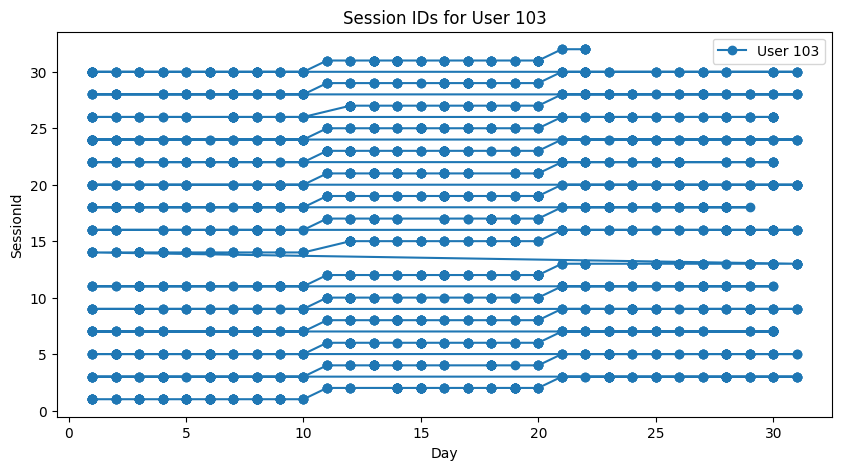

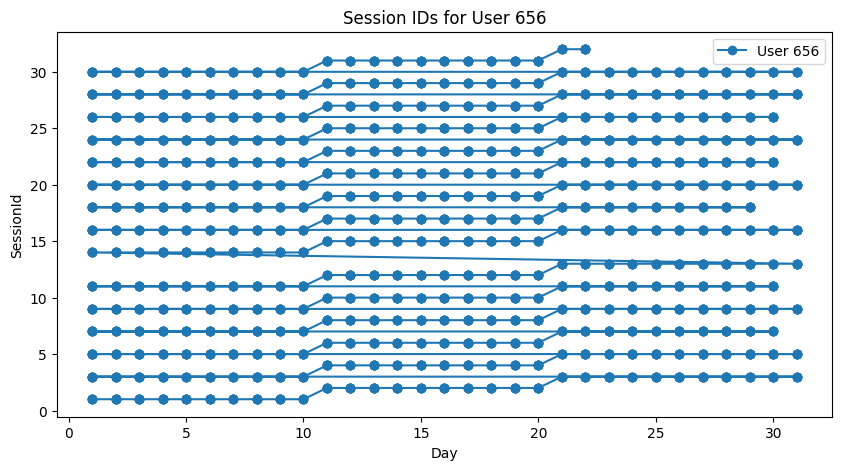

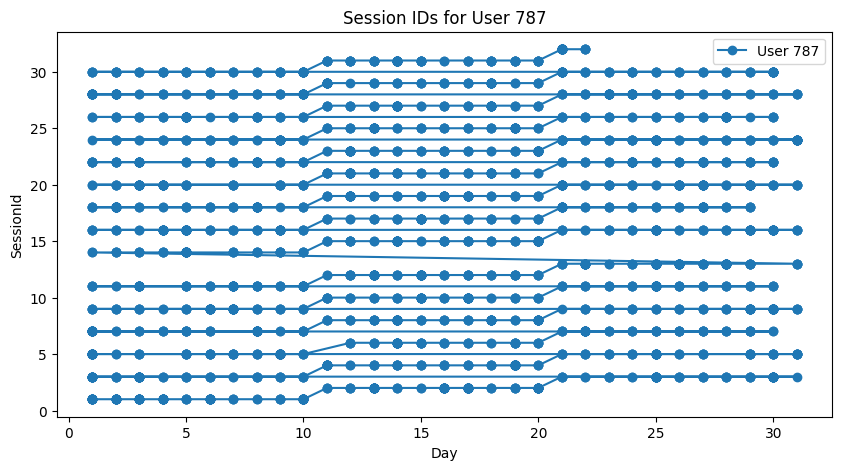

In [ ]:
import matplotlib.pyplot as plt

user_ids_to_plot = df['UserId'].unique()[:3]
for user_id in user_ids_to_plot:
    user_data = df[df['UserId'] == user_id]
    plt.figure(figsize=(10, 5))
    plt.plot(user_data['Day'], user_data['SessionId'], marker='o', linestyle='-', label=f'User {user_id}')
    plt.xlabel('Day')
    plt.ylabel('SessionId')
    plt.title(f'Session IDs for User {user_id}')
    plt.legend()
    plt.show()


In [ ]:
print(df.groupby('UserId')['SessionId'].nunique())

UserId
0      31
1      32
2      31
3      31
4      31
       ..
995    31
996    32
997    32
998    32
999    31
Name: SessionId, Length: 1000, dtype: int64


In [ ]:
# Filter rows where Day is 3 and Month is 1
filtered_df = df[(df['Day'] == 3) & (df['Month'] == 1)]

# Print the filtered rows
print(filtered_df)


         UserId  VenueId  VenueType       Date       GeoHash  Month  hour  \
1064716      64        0          0 2020-01-03  131916353526      1     0   
1064717      81      273          0 2020-01-03  131916353527      1     0   
1064718     208      535          0 2020-01-03  131916353528      1     0   
1064719     629        0          0 2020-01-03  131916353528      1     0   
1064720     638     1472          0 2020-01-03  131916353528      1     0   
...         ...      ...        ...        ...           ...    ...   ...   
1070130     180     1760          1 2020-01-03   13235112511      1    23   
1070131     544     1308          0 2020-01-03  131916353530      1    23   
1070132     728      175          0 2020-01-03  131916353522      1    23   
1070133     771     1751          1 2020-01-03     132317000      1    23   
1070134     988      850          0 2020-01-03  131916353520      1    23   

         Season  Part of Day  dayofweek  is_weekday  Year  Day  SessionId  

In [ ]:
df[(df['UserId'] == 180)]

,UserId,VenueId,VenueType,Date,GeoHash,Month,hour,Season,Part of Day,dayofweek,is_weekday,Year,Day,SessionId
1194,180,1571,3,2019-07-01,13235112511,7,8,3,2,0,1,2019,1,1
3457,180,1774,2,2019-07-01,13235112511,7,15,3,3,0,1,2019,1,1
3858,180,1571,3,2019-07-01,13235112511,7,16,3,3,0,1,2019,1,1
4641,180,849,0,2019-07-01,13235112511,7,17,3,3,0,1,2019,1,1
4780,180,1760,1,2019-07-01,13235112511,7,17,3,3,0,1,2019,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2477652,180,1571,3,2020-09-22,13235112511,9,8,4,2,1,1,2020,22,32
2479417,180,1774,2,2020-09-22,13235112511,9,15,4,3,1,1,2020,22,32
2479698,180,1571,3,2020-09-22,13235112511,9,16,4,3,1,1,2020,22,32
2480252,180,849,0,2020-09-22,13235112511,9,17,4,3,1,1,2020,22,32


In [ ]:
filename = 'Session_df.tsv'
file_path_tsv = '/content/drive/MyDrive/Spatio_Temporal_Lab/Session_df_2.tsv'
df.to_csv(file_path_tsv, sep='\t', index=False)

#EDA for further modelling of LSTM

##Discretizing Data

In [ ]:
features_df = pd.read_csv('/content/drive/MyDrive/Spatio_Temporal_Lab/Session_df.tsv', delimiter='\t')

In [ ]:
features_df.drop(columns=['Date', 'Year', 'Day'], inplace=True)

In [ ]:
##Encoding the GeoHash values
# Get unique GeoHash values
unique_geohash_values = features_df['GeoHash'].unique()

# Create a mapping from each unique GeoHash value to a unique bin index
geohash_to_bins = {value: idx for idx, value in enumerate(unique_geohash_values)}

# Map the bins back to the original GeoHash column
features_df['GeoHash_binned'] = features_df['GeoHash'].map(geohash_to_bins)

print(features_df[['GeoHash', 'GeoHash_binned']])

              GeoHash  GeoHash_binned
0        131916353535               0
1        131916353522               1
2         13235112511               2
3         13235112511               2
4          1323511259               3
...               ...             ...
2481769    1323511252              10
2481770  131916353519               7
2481771  131916353530               4
2481772     132317000              16
2481773  131916353530               4

[2481774 rows x 2 columns]


In [ ]:
len(unique_geohash_values)

35

In [ ]:
# Encode VenueId
label_encoder = LabelEncoder()
features_df['VenueId_encoded'] = label_encoder.fit_transform(features_df['VenueId'])

# Print the DataFrame to see the encoded VenueId
print(features_df[['VenueId', 'VenueId_encoded']].head())

   VenueId  VenueId_encoded
0     1755              968
1     1773              986
2     1752              965
3     1752              965
4     1754              967


In [ ]:
features_df.drop(columns=['VenueId', 'GeoHash'], inplace= True)

In [ ]:
features_df.head()

,UserId,VenueType,Month,hour,Season,Part of Day,dayofweek,is_weekday,SessionId,GeoHash_binned,VenueId_encoded
0,103,1,7,5,3,1,0,1,1,0,968
1,656,2,7,5,3,1,0,1,1,1,986
2,787,1,7,5,3,1,0,1,1,2,965
3,828,1,7,5,3,1,0,1,1,2,965
4,244,1,7,5,3,1,0,1,1,3,967


##Convert to sequences and pad data

In [ ]:
##Join data depending on each session
# Group by UserId and SessionId and aggregate to lists
#UserId	VenueId	VenueType	X	Y	Date	Time	SocialLinkUser	Year	Month	Day	hour	minute	second	Season	Part of Day	dayofweek	is_weekday
features_df = features_df.groupby(['UserId', 'SessionId']).agg({
    'VenueId_encoded': list,
    'VenueType': list,
    'GeoHash_binned': list,
    'Month': list,
    'hour': list,
    'Season': list,
    'Part of Day': list,
    'dayofweek': list,
    'is_weekday': list
}).reset_index()

In [ ]:
features_df.head()

,UserId,SessionId,VenueId_encoded,VenueType,GeoHash_binned,Month,hour,Season,Part of Day,dayofweek,is_weekday
0,0,1,"[921, 979, 921, 1, 921, 1, 965, 1, 965, 1, 966...","[3, 2, 3, 0, 3, 0, 1, 0, 1, 0, 1, 0, 3, 0, 1, ...","[3, 6, 3, 16, 3, 16, 2, 16, 2, 16, 2, 16, 3, 1...","[7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, ...","[7, 12, 13, 16, 7, 16, 16, 19, 19, 20, 21, 23,...","[3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, ...","[2, 3, 3, 3, 2, 3, 3, 4, 4, 4, 4, 4, 2, 3, 3, ...","[0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
1,0,2,"[921, 1, 966, 1, 965, 1, 921, 1, 965, 1, 965, ...","[3, 0, 1, 0, 1, 0, 3, 0, 1, 0, 1, 0, 1, 0, 2, ...","[3, 16, 2, 16, 2, 16, 3, 16, 2, 16, 2, 16, 0, ...","[7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, ...","[7, 16, 16, 18, 18, 21, 7, 16, 16, 18, 18, 20,...","[3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, ...","[2, 3, 3, 4, 4, 4, 2, 3, 3, 4, 4, 4, 4, 4, 1, ...","[3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 5, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, ..."
2,0,3,"[982, 1, 921, 1, 968, 1, 968, 1, 964, 1, 968, ...","[2, 0, 3, 0, 1, 0, 1, 0, 1, 0, 1, 0, 3, 0, 3, ...","[11, 16, 3, 16, 0, 16, 0, 16, 16, 16, 0, 16, 3...","[7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, ...","[0, 0, 7, 16, 16, 17, 18, 19, 19, 20, 20, 22, ...","[3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, ...","[1, 1, 2, 3, 3, 3, 4, 4, 4, 4, 4, 4, 2, 3, 2, ...","[6, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 2, ...","[0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
3,0,4,"[982, 1, 921, 1, 973, 1, 965, 1, 965, 1, 921, ...","[2, 0, 3, 0, 1, 0, 1, 0, 1, 0, 3, 0, 1, 0, 1, ...","[11, 16, 3, 16, 2, 16, 2, 16, 2, 16, 3, 16, 2,...","[8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, ...","[7, 8, 7, 16, 16, 18, 18, 19, 20, 21, 7, 16, 1...","[3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, ...","[2, 2, 2, 3, 3, 4, 4, 4, 4, 4, 2, 3, 3, 3, 3, ...","[6, 6, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, ...","[0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
4,0,5,"[921, 1, 921, 1, 921, 1, 982, 1, 982, 1, 982, ...","[3, 0, 3, 0, 3, 0, 2, 0, 2, 0, 2, 0, 3, 0, 1, ...","[3, 16, 3, 16, 3, 16, 11, 16, 11, 16, 11, 16, ...","[8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, ...","[7, 16, 7, 16, 7, 16, 0, 0, 7, 8, 0, 0, 7, 16,...","[3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, ...","[2, 3, 2, 3, 2, 3, 1, 1, 2, 2, 1, 1, 2, 3, 3, ...","[2, 2, 3, 3, 4, 4, 5, 5, 5, 5, 6, 6, 0, 0, 0, ...","[1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, ..."


In [ ]:
len(features_df)

31495

In [ ]:
def get_max_sequence_length_column(df, column_name):
    max_length = 0
    if isinstance(df[column_name].iloc[0], list):
        max_length = max(len(seq) for seq in df[column_name])
    return max_length

# Example usage for 'VenueId' column:
max_sequence_length_venue_id = get_max_sequence_length_column(features_df, 'VenueId_encoded')
print(f"Maximum sequence length in the 'VenueId' column: {max_sequence_length_venue_id}")


Maximum sequence length in the 'VenueId' column: 254


In [ ]:
def get_min_sequence_length_column(df, column_name):
    min_length = float('inf')  # Initialize to a large value
    if isinstance(df[column_name].iloc[0], list):
        min_length = min(len(seq) for seq in df[column_name])
    return min_length if min_length != float('inf') else 0  # Return 0 if no lists are found

# Example usage for 'VenueId_encoded' column:
min_sequence_length_venue_id_encoded = get_min_sequence_length_column(features_df, 'VenueId_encoded')
print(f"Minimum sequence length in the 'VenueId_encoded' column: {min_sequence_length_venue_id_encoded}")


Minimum sequence length in the 'VenueId_encoded' column: 2


In [ ]:
def get_most_unique_max_values_column(df, column_name, top_n=10):
    max_values = []
    if isinstance(df[column_name].iloc[0], list):
        lengths = [len(seq) for seq in df[column_name]]
        unique_lengths = set(lengths)
        max_values.extend(unique_lengths)

    # Sort and get the top_n most unique maximum values
    sorted_unique_max_values = sorted(max_values, key=lambda x: (max_values.count(x), x), reverse=True)
    most_unique_max_values = sorted(set(sorted_unique_max_values[:top_n]))

    return most_unique_max_values

# Example usage for 'VenueId_encoded' column:
most_unique_max_lengths_venue_id_encoded = get_most_unique_max_values_column(features_df, 'VenueId_encoded')
print(f"10 most unique maximum values in sequence lengths in 'VenueId_encoded' column: {most_unique_max_lengths_venue_id_encoded}")


10 most unique maximum values in sequence lengths in 'VenueId_encoded' column: [204, 205, 208, 212, 218, 226, 230, 238, 248, 254]


In [ ]:
def get_least_unique_max_values_column(df, column_name, top_n=10):
    max_values = []
    if isinstance(df[column_name].iloc[0], list):
        lengths = [len(seq) for seq in df[column_name]]
        unique_lengths = set(lengths)
        max_values.extend(unique_lengths)

    # Sort and get the top_n least unique maximum values
    sorted_unique_max_values = sorted(max_values, key=lambda x: (-max_values.count(x), x))
    least_unique_max_values = sorted(set(sorted_unique_max_values[:top_n]))

    return least_unique_max_values

least_unique_max_lengths_venue_id_encoded = get_least_unique_max_values_column(features_df, 'VenueId_encoded')
print(f"10 least unique maximum values in sequence lengths in 'VenueId_encoded' column: {least_unique_max_lengths_venue_id_encoded}")


10 least unique maximum values in sequence lengths in 'VenueId_encoded' column: [2, 3, 4, 5, 6, 7, 8, 9, 10, 11]


In [ ]:
def count_sequences_below_length_column(df, column_name, threshold):
    count = 0
    if isinstance(df[column_name].iloc[0], list):
        lengths = [len(seq) for seq in df[column_name]]
        count += sum(1 for length in lengths if length < threshold)
    return count

threshold_value = 200
sequences_below_threshold_venue_id_encoded = count_sequences_below_length_column(features_df, 'VenueId_encoded', threshold_value)
print(f"Number of sequences below length {threshold_value} in 'VenueId_encoded' column: {sequences_below_threshold_venue_id_encoded}")


Number of sequences below length 200 in 'VenueId_encoded' column: 31479


In [ ]:
def count_sequences_below_length_column(df, column_name, threshold):
    count = 0
    if isinstance(df[column_name].iloc[0], list):
        lengths = [len(seq) for seq in df[column_name]]
        count += sum(1 for length in lengths if length < threshold)
    return count

threshold_value = 30
sequences_below_threshold_venue_id_encoded = count_sequences_below_length_column(features_df, 'VenueId_encoded', threshold_value)
print(f"Number of sequences below length {threshold_value} in 'VenueId_encoded' column: {sequences_below_threshold_venue_id_encoded}")


Number of sequences below length 30 in 'VenueId_encoded' column: 1373


In [ ]:
def count_sequences_below_length_column(df, column_name, threshold):
    count = 0
    if isinstance(df[column_name].iloc[0], list):
        lengths = [len(seq) for seq in df[column_name]]
        count += sum(1 for length in lengths if length < threshold)
    return count

threshold_value = 10
sequences_below_threshold_venue_id_encoded = count_sequences_below_length_column(features_df, 'VenueId_encoded', threshold_value)
print(f"Number of sequences below length {threshold_value} in 'VenueId_encoded' column: {sequences_below_threshold_venue_id_encoded}")


Number of sequences below length 10 in 'VenueId_encoded' column: 441


In [ ]:
def count_sequences_below_length_column(df, column_name, threshold):
    count = 0
    if isinstance(df[column_name].iloc[0], list):
        lengths = [len(seq) for seq in df[column_name]]
        count += sum(1 for length in lengths if length < threshold)
    return count


threshold_value = 9
sequences_below_threshold_venue_id_encoded = count_sequences_below_length_column(features_df, 'VenueId_encoded', threshold_value)
print(f"Number of sequences below length {threshold_value} in 'VenueId_encoded' column: {sequences_below_threshold_venue_id_encoded}")


Number of sequences below length 9 in 'VenueId_encoded' column: 356


In [ ]:
def count_sequences_below_length_column(df, column_name, threshold):
    count = 0
    if isinstance(df[column_name].iloc[0], list):
        lengths = [len(seq) for seq in df[column_name]]
        count += sum(1 for length in lengths if length < threshold)
    return count


threshold_value = 8
sequences_below_threshold_venue_id_encoded = count_sequences_below_length_column(features_df, 'VenueId_encoded', threshold_value)
print(f"Number of sequences below length {threshold_value} in 'VenueId_encoded' column: {sequences_below_threshold_venue_id_encoded}")


Number of sequences below length 8 in 'VenueId_encoded' column: 144


In [ ]:
def count_sequences_below_length_column(df, column_name, threshold):
    count = 0
    if isinstance(df[column_name].iloc[0], list):
        lengths = [len(seq) for seq in df[column_name]]
        count += sum(1 for length in lengths if length < threshold)
    return count


threshold_value = 7
sequences_below_threshold_venue_id_encoded = count_sequences_below_length_column(features_df, 'VenueId_encoded', threshold_value)
print(f"Number of sequences below length {threshold_value} in 'VenueId_encoded' column: {sequences_below_threshold_venue_id_encoded}")


Number of sequences below length 7 in 'VenueId_encoded' column: 142


In [ ]:
def count_sequences_below_length_column(df, column_name, threshold):
    count = 0
    if isinstance(df[column_name].iloc[0], list):
        lengths = [len(seq) for seq in df[column_name]]
        count += sum(1 for length in lengths if length < threshold)
    return count

threshold_value = 5
sequences_below_threshold_venue_id_encoded = count_sequences_below_length_column(features_df, 'VenueId_encoded', threshold_value)
print(f"Number of sequences below length {threshold_value} in 'VenueId_encoded' column: {sequences_below_threshold_venue_id_encoded}")


Number of sequences below length 5 in 'VenueId_encoded' column: 70


In [ ]:
def count_sequences_below_length_column(df, column_name, threshold):
    count = 0
    if isinstance(df[column_name].iloc[0], list):
        lengths = [len(seq) for seq in df[column_name]]
        count += sum(1 for length in lengths if length < threshold)
    return count

threshold_value = 3
sequences_below_threshold_venue_id_encoded = count_sequences_below_length_column(features_df, 'VenueId_encoded', threshold_value)
print(f"Number of sequences below length {threshold_value} in 'VenueId_encoded' column: {sequences_below_threshold_venue_id_encoded}")


Number of sequences below length 3 in 'VenueId_encoded' column: 3


In [ ]:
features_df.shape

(31495, 11)

In [ ]:
##Remove sequence below 30

data_df = features_df.copy()

# Filter out sequences below length 30 in 'VenueId_encoded' column
data_df = data_df[data_df['VenueId_encoded'].apply(lambda x: len(x) >= 30)]

# Example usage:
print(f"Number of rows after filtering: {len(data_df)}")


Number of rows after filtering: 30122


##Padding EDA

In [ ]:
def count_sequences_below_length_column(df, column_name, threshold):
    count = 0
    if isinstance(df[column_name].iloc[0], list):
        lengths = [len(seq) for seq in df[column_name]]
        count += sum(1 for length in lengths if length < threshold)
    return count

threshold_value = 300
sequences_below_threshold_venue_id_encoded = count_sequences_below_length_column(data_df, 'VenueId_encoded', threshold_value)
print(f"Number of sequences below length {threshold_value} in 'VenueId_encoded' column: {sequences_below_threshold_venue_id_encoded}")


Number of sequences below length 300 in 'VenueId_encoded' column: 30122


In [ ]:
def count_sequences_below_length_column(df, column_name, threshold):
    count = 0
    if isinstance(df[column_name].iloc[0], list):
        lengths = [len(seq) for seq in df[column_name]]
        count += sum(1 for length in lengths if length < threshold)
    return count

threshold_value = 200
sequences_below_threshold_venue_id_encoded = count_sequences_below_length_column(data_df, 'VenueId_encoded', threshold_value)
print(f"Number of sequences below length {threshold_value} in 'VenueId_encoded' column: {sequences_below_threshold_venue_id_encoded}")


Number of sequences below length 200 in 'VenueId_encoded' column: 30106


In [ ]:
def count_sequences_below_length_column(df, column_name, threshold):
    count = 0
    if isinstance(df[column_name].iloc[0], list):
        lengths = [len(seq) for seq in df[column_name]]
        count += sum(1 for length in lengths if length < threshold)
    return count

threshold_value = 180
sequences_below_threshold_venue_id_encoded = count_sequences_below_length_column(data_df, 'VenueId_encoded', threshold_value)
print(f"Number of sequences below length {threshold_value} in 'VenueId_encoded' column: {sequences_below_threshold_venue_id_encoded}")


Number of sequences below length 180 in 'VenueId_encoded' column: 30052


In [ ]:
def count_sequences_below_length_column(df, column_name, threshold):
    count = 0
    if isinstance(df[column_name].iloc[0], list):
        lengths = [len(seq) for seq in df[column_name]]
        count += sum(1 for length in lengths if length < threshold)
    return count

threshold_value = 150
sequences_below_threshold_venue_id_encoded = count_sequences_below_length_column(data_df, 'VenueId_encoded', threshold_value)
print(f"Number of sequences below length {threshold_value} in 'VenueId_encoded' column: {sequences_below_threshold_venue_id_encoded}")


Number of sequences below length 150 in 'VenueId_encoded' column: 29226


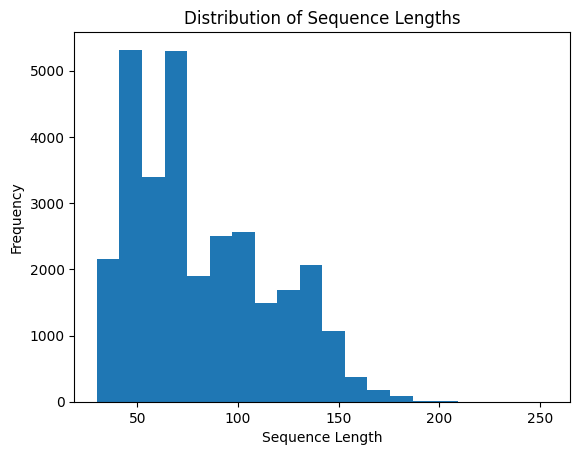

In [ ]:
#Visualise distribution of data

import matplotlib.pyplot as plt

sequence_lengths = data_df['VenueId_encoded'].apply(len)

plt.hist(sequence_lengths, bins=20)
plt.xlabel('Sequence Length')
plt.ylabel('Frequency')
plt.title('Distribution of Sequence Lengths')
plt.show()


In [ ]:
import numpy as np

percentiles = np.percentile(sequence_lengths, [50, 75, 90, 95, 99])
print("50th percentile (median):", percentiles[0])
print("75th percentile:", percentiles[1])
print("90th percentile:", percentiles[2])
print("95th percentile:", percentiles[3])
print("99th percentile:", percentiles[4])


50th percentile (median): 71.0
75th percentile: 106.0
90th percentile: 135.0
95th percentile: 142.0
99th percentile: 164.0


##Pad

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
def split_sequence(sequence, train_ratio=0.8):

    split_point = int(len(sequence) * train_ratio)
    return sequence[:split_point], sequence[split_point:]

# Initialize lists to hold split data
train_data = []
test_data = []

# Iterate over each row and split the sequences for all columns
for _, row in data_df.iterrows():
    train_row = row.copy()
    test_row = row.copy()
    for column in data_df.columns:
        if isinstance(row[column], list):
            train_seq, test_seq = split_sequence(row[column])
            train_row[column] = train_seq
            test_row[column] = test_seq
        else:
            train_row[column] = row[column]
            test_row[column] = row[column]
    train_data.append(train_row)
    test_data.append(test_row)

# Create DataFrames for train and test splits
train_df = pd.DataFrame(train_data)
test_df = pd.DataFrame(test_data)


In [ ]:
# Calculate max and min sequence lengths for train_df
train_df['VenueId_length'] = train_df['VenueId_encoded'].apply(len)
train_max_length = train_df['VenueId_length'].max()
train_min_length = train_df['VenueId_length'].min()

# Calculate max and min sequence lengths for test_df
test_df['VenueId_length'] = test_df['VenueId_encoded'].apply(len)
test_max_length = test_df['VenueId_length'].max()
test_min_length = test_df['VenueId_length'].min()

In [ ]:
# Display the results
print(f"Train DataFrame - Max sequence length: {train_max_length}, Min sequence length: {train_min_length}")

print(f"Test DataFrame - Max sequence length: {test_max_length}, Min sequence length: {test_min_length}")


Train DataFrame - Max sequence length: 203, Min sequence length: 24
Test DataFrame - Max sequence length: 51, Min sequence length: 6


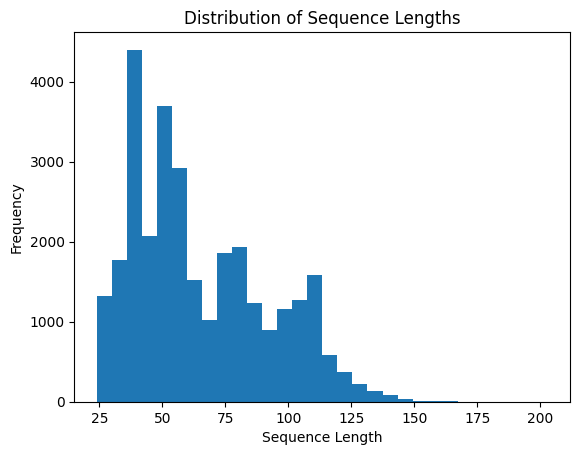

In [ ]:
#Visualise distribution of data

import matplotlib.pyplot as plt

sequence_lengths = train_df['VenueId_encoded'].apply(len)

plt.hist(sequence_lengths, bins=30)
plt.xlabel('Sequence Length')
plt.ylabel('Frequency')
plt.title('Distribution of Sequence Lengths')
plt.show()


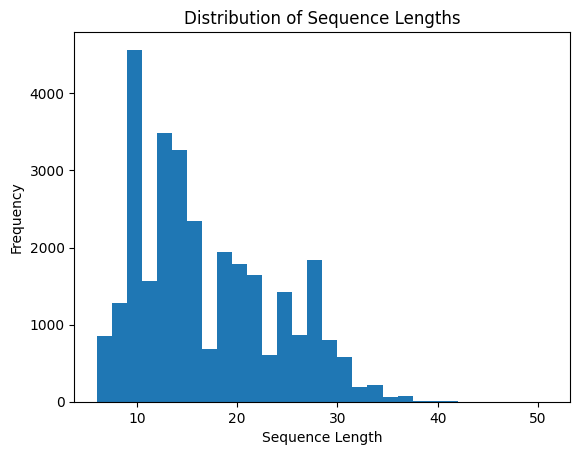

In [ ]:
#Visualise distribution of data

import matplotlib.pyplot as plt

sequence_lengths = test_df['VenueId_encoded'].apply(len)

plt.hist(sequence_lengths, bins=30)
plt.xlabel('Sequence Length')
plt.ylabel('Frequency')
plt.title('Distribution of Sequence Lengths')
plt.show()


In [ ]:
def pad_or_truncate_sequence(seq, target_length):
    """
    Pad or truncate a sequence to the target length.
    """
    if len(seq) > target_length:
        return seq[:target_length]
    else:
        return seq + [0] * (target_length - len(seq))



In [ ]:
# Set the desired length for padding and truncating
target_length_train = 125

for column in train_df.columns:
    if isinstance(train_df[column].iloc[0], list):
        train_df[column] = train_df[column].apply(lambda x: pad_or_truncate_sequence(x, target_length_train))

In [ ]:
# Set the desired length for padding and truncating
target_length_test = 125

for column in test_df.columns:
    if isinstance(test_df[column].iloc[0], list):
        test_df[column] = test_df[column].apply(lambda x: pad_or_truncate_sequence(x, target_length_test))



In [ ]:
train_df.head()

,UserId,SessionId,VenueId_encoded,VenueType,GeoHash_binned,Month,hour,Season,Part of Day,dayofweek,is_weekday,VenueId_length
0,0,1,"[921, 979, 921, 1, 921, 1, 965, 1, 965, 1, 966...","[3, 2, 3, 0, 3, 0, 1, 0, 1, 0, 1, 0, 3, 0, 1, ...","[3, 6, 3, 16, 3, 16, 2, 16, 2, 16, 2, 16, 3, 1...","[7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, ...","[7, 12, 13, 16, 7, 16, 16, 19, 19, 20, 21, 23,...","[3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, ...","[2, 3, 3, 3, 2, 3, 3, 4, 4, 4, 4, 4, 2, 3, 3, ...","[0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",51
1,0,2,"[921, 1, 966, 1, 965, 1, 921, 1, 965, 1, 965, ...","[3, 0, 1, 0, 1, 0, 3, 0, 1, 0, 1, 0, 1, 0, 2, ...","[3, 16, 2, 16, 2, 16, 3, 16, 2, 16, 2, 16, 0, ...","[7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, ...","[7, 16, 16, 18, 18, 21, 7, 16, 16, 18, 18, 20,...","[3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, ...","[2, 3, 3, 4, 4, 4, 2, 3, 3, 4, 4, 4, 4, 4, 1, ...","[3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 5, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, ...",32
2,0,3,"[982, 1, 921, 1, 968, 1, 968, 1, 964, 1, 968, ...","[2, 0, 3, 0, 1, 0, 1, 0, 1, 0, 1, 0, 3, 0, 3, ...","[11, 16, 3, 16, 0, 16, 0, 16, 16, 16, 0, 16, 3...","[7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, ...","[0, 0, 7, 16, 16, 17, 18, 19, 19, 20, 20, 22, ...","[3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, ...","[1, 1, 2, 3, 3, 3, 4, 4, 4, 4, 4, 4, 2, 3, 2, ...","[6, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 2, ...","[0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",68
3,0,4,"[982, 1, 921, 1, 973, 1, 965, 1, 965, 1, 921, ...","[2, 0, 3, 0, 1, 0, 1, 0, 1, 0, 3, 0, 1, 0, 1, ...","[11, 16, 3, 16, 2, 16, 2, 16, 2, 16, 3, 16, 2,...","[8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, ...","[7, 8, 7, 16, 16, 18, 18, 19, 20, 21, 7, 16, 1...","[3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, ...","[2, 2, 2, 3, 3, 4, 4, 4, 4, 4, 2, 3, 3, 3, 3, ...","[6, 6, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, ...","[0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",38
4,0,5,"[921, 1, 921, 1, 921, 1, 982, 1, 982, 1, 982, ...","[3, 0, 3, 0, 3, 0, 2, 0, 2, 0, 2, 0, 3, 0, 1, ...","[3, 16, 3, 16, 3, 16, 11, 16, 11, 16, 11, 16, ...","[8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, ...","[7, 16, 7, 16, 7, 16, 0, 0, 7, 8, 0, 0, 7, 16,...","[3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, ...","[2, 3, 2, 3, 2, 3, 1, 1, 2, 2, 1, 1, 2, 3, 3, ...","[2, 2, 3, 3, 4, 4, 5, 5, 5, 5, 6, 6, 0, 0, 0, ...","[1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, ...",49


In [ ]:
test_df.head()

,UserId,SessionId,VenueId_encoded,VenueType,GeoHash_binned,Month,hour,Season,Part of Day,dayofweek,is_weekday,VenueId_length
0,0,1,"[1, 965, 1, 921, 1, 973, 1, 965, 1, 964, 1, 92...","[0, 1, 0, 3, 0, 1, 0, 1, 0, 1, 0, 3, 0, 0, 0, ...","[16, 2, 16, 3, 16, 2, 16, 2, 16, 16, 16, 3, 16...","[7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 0, 0, ...","[19, 19, 21, 7, 16, 16, 18, 18, 20, 20, 22, 7,...","[3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 0, 0, ...","[4, 4, 4, 2, 3, 3, 4, 4, 4, 4, 4, 2, 3, 0, 0, ...","[0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 0, 0, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, ...",13
1,0,2,"[966, 1, 964, 1, 921, 1, 982, 1, 0, 0, 0, 0, 0...","[1, 0, 1, 0, 3, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, ...","[2, 16, 16, 16, 3, 16, 11, 16, 0, 0, 0, 0, 0, ...","[7, 7, 7, 7, 7, 7, 7, 7, 0, 0, 0, 0, 0, 0, 0, ...","[18, 19, 20, 21, 7, 16, 0, 0, 0, 0, 0, 0, 0, 0...","[3, 3, 3, 3, 3, 3, 3, 3, 0, 0, 0, 0, 0, 0, 0, ...","[4, 4, 4, 4, 2, 3, 1, 1, 0, 0, 0, 0, 0, 0, 0, ...","[3, 3, 3, 3, 4, 4, 5, 5, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",8
2,0,3,"[921, 1, 921, 1, 921, 1, 964, 1, 965, 1, 968, ...","[3, 0, 3, 0, 3, 0, 1, 0, 1, 0, 1, 0, 3, 0, 3, ...","[3, 16, 3, 16, 3, 16, 16, 16, 2, 16, 0, 16, 3,...","[8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, ...","[7, 16, 7, 16, 7, 16, 16, 18, 18, 20, 20, 21, ...","[3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, ...","[2, 3, 2, 3, 2, 3, 3, 4, 4, 4, 4, 4, 2, 3, 2, ...","[0, 0, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 4, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",18
3,0,4,"[965, 1, 965, 1, 965, 1, 921, 1, 921, 1, 0, 0,...","[1, 0, 1, 0, 1, 0, 3, 0, 3, 0, 0, 0, 0, 0, 0, ...","[2, 16, 2, 16, 2, 16, 3, 16, 3, 16, 0, 0, 0, 0...","[8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 0, 0, 0, 0, 0, ...","[8, 10, 10, 12, 12, 14, 7, 16, 7, 16, 0, 0, 0,...","[3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 0, 0, 0, 0, 0, ...","[2, 2, 2, 3, 3, 3, 2, 3, 2, 3, 0, 0, 0, 0, 0, ...","[6, 6, 6, 6, 6, 6, 0, 0, 1, 1, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, ...",10
4,0,5,"[1, 982, 1, 966, 1, 964, 1, 965, 1, 921, 1, 92...","[0, 2, 0, 1, 0, 1, 0, 1, 0, 3, 0, 3, 0, 0, 0, ...","[16, 11, 16, 2, 16, 16, 16, 2, 16, 3, 16, 3, 1...","[9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 0, 0, ...","[0, 7, 8, 8, 10, 10, 11, 12, 14, 7, 16, 7, 16,...","[4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 0, 0, ...","[1, 2, 2, 2, 2, 2, 2, 3, 3, 2, 3, 2, 3, 0, 0, ...","[6, 6, 6, 6, 6, 6, 6, 6, 6, 0, 0, 1, 1, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, ...",13


In [ ]:
# Calculate max and min sequence lengths for train_df
train_df['VenueId_length'] = train_df['VenueId_encoded'].apply(len)
train_max_length = train_df['VenueId_length'].max()
train_min_length = train_df['VenueId_length'].min()

# Calculate max and min sequence lengths for test_df
test_df['VenueId_length'] = test_df['VenueId_encoded'].apply(len)
test_max_length = test_df['VenueId_length'].max()
test_min_length = test_df['VenueId_length'].min()

In [ ]:
# Display the results
print(f"Train DataFrame - Max sequence length: {train_max_length}, Min sequence length: {train_min_length}")

print(f"Test DataFrame - Max sequence length: {test_max_length}, Min sequence length: {test_min_length}")


Train DataFrame - Max sequence length: 125, Min sequence length: 125
Test DataFrame - Max sequence length: 125, Min sequence length: 125
